# Criteo 1 TiB benchmark - Spark.ML logistic regression

Specialization of the experiment notebook for Spark.ML logistic regression.

# Table of contents

* [Configuration](#Configuration)
* [Distributed training](#Distributed-training)
* [End](#End)

In [1]:
# coding=utf-8
%load_ext autotime
%matplotlib inline

from __future__ import print_function

time: 321 ms (started: 2022-11-16 12:58:51 +00:00)


## Configuration
[_(back to toc)_](#Table-of-contents)

Paths:

In [2]:
libsvm_data_remote_path = 'criteo/libsvm'
local_runtime_path = 'criteo/runtime'

time: 829 µs (started: 2022-11-16 12:58:51 +00:00)


In [3]:
import os


libsvm_train_template = os.path.join(libsvm_data_remote_path, 'train', '{}')
libsvm_test_template = os.path.join(libsvm_data_remote_path, 'test', '{}')

time: 966 µs (started: 2022-11-16 12:58:51 +00:00)


In [4]:
def ensure_directory_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

time: 798 µs (started: 2022-11-16 12:58:51 +00:00)


Samples to take:

In [5]:
train_samples = [
    10000, 30000,  # tens of thousands
    100000, 300000,  # hundreds of thousands
    1000000, 3000000,  # millions
    10000000, 30000000,  # tens of millions
    100000000, 300000000,  # hundreds of millions
    1000000000, 3000000000,  # billions
]

test_samples = [1000000]

time: 973 µs (started: 2022-11-16 12:58:52 +00:00)


Spark configuration and initialization:

In [6]:
total_cores = 256

time: 571 µs (started: 2022-11-16 12:58:52 +00:00)


In [7]:
executor_cores = 4
executor_instances = total_cores / executor_cores
memory_per_core = 2

time: 808 µs (started: 2022-11-16 12:58:52 +00:00)


In [8]:
app_name = 'Criteo experiment - LR on 128 cores'

master = 'yarn'

settings = {
    'spark.network.timeout': '600',
    
    'spark.driver.cores': '16',
    'spark.driver.maxResultSize': '16G',
    'spark.driver.memory': '32G',
    
    'spark.executor.cores': str(executor_cores),
    'spark.executor.instances': str(executor_instances),
    'spark.executor.memory': str(memory_per_core * executor_cores) + 'G',
    
    'spark.speculation': 'true',
    
    'spark.yarn.queue': 'root.HungerGames',
}

time: 1.43 ms (started: 2022-11-16 12:58:52 +00:00)


In [9]:
import findspark
findspark.init('/data/dataset/fengwen/script/data/spark-3.3.1-bin-hadoop3-scala2.13')
from pyspark import SparkContext
sc = SparkContext('local','pyspark')
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/fengwen/miniconda3/envs/spark/bin/jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = " --ip=0.0.0.0 --port=7777"
# jupyter: /home/fengwen/miniconda3/envs/spark/bin/jupyter

22/11/16 12:58:53 WARN Utils: Your hostname, oneflow-27 resolves to a loopback address: 127.0.1.1; using 192.168.1.27 instead (on interface ens121f0)
22/11/16 12:58:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 12:58:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
time: 2.93 s (started: 2022-11-16 12:58:52 +00:00)


In [10]:
from pyspark.sql import SparkSession


builder = SparkSession.builder

builder.appName(app_name)
builder.master(master)
for k, v in settings.items():
    builder.config(k, v)

spark = builder.getOrCreate()
sc = spark.sparkContext

sc.setLogLevel('ERROR')

time: 111 ms (started: 2022-11-16 12:58:55 +00:00)


Logging:

In [11]:
import sys
import logging
from importlib import reload # 添加
logging.shutdown()            # 添加
reload(logging)              # 在 reload(logging) 前添加两行代码


handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('[%(asctime)s] %(message)s')
handler.setFormatter(formatter)

ensure_directory_exists(local_runtime_path)
file_handler = logging.FileHandler(filename=os.path.join(local_runtime_path, 'mylog.log'), mode='a')
file_handler.setFormatter(formatter)

logger = logging.getLogger()
logger.addHandler(handler)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

time: 3.33 ms (started: 2022-11-16 12:58:55 +00:00)


In [12]:
logger.info('Spark version: %s.', spark.version)

[2022-11-16 12:58:55,850] Spark version: 3.3.1.
time: 2.2 ms (started: 2022-11-16 12:58:55 +00:00)


Plot measurements:

In [13]:
import pandas
from functools import reduce


def extract_data_for_plotting(df, what):
    return reduce(
        lambda left, right: pandas.merge(left, right, how='outer', on='Train size'),
        map(
            lambda name: df[df.Engine == name][['Train size', what]].rename(columns={what: name}),
            df.Engine.unique(),
        ),
    )   

def plot_stuff(df, what, ylabel=None, **kwargs):
    data = extract_data_for_plotting(df, what).set_index('Train size')
    ax = data.plot(marker='o', figsize=(6, 6), title=what, grid=True, linewidth=2.0, **kwargs)  # xlim=(1e4, 4e9)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

time: 123 ms (started: 2022-11-16 12:58:56 +00:00)


Let's name samples as their shortened "engineering" notation - 1e5 is 100k etc.:

In [14]:
def sample_name(sample):
    return str(sample)[::-1].replace('000', 'k')[::-1]

time: 936 µs (started: 2022-11-16 12:58:56 +00:00)


## Distributed training
[_(back to toc)_](#Table-of-contents)

Loading of LibSVM data as Spark.ML dataset:

In [15]:
import hashlib
import math
import struct
from pyspark.ml.linalg import SparseVector


total_features = 100000


def hash_fun(x):
    return int(struct.unpack('L', hashlib.md5(x.encode("utf-8")).digest()[:8])[0] % total_features)

def parse_kv_pair(kv):
    k, _, v = kv.partition(':')
    return int(k), int(v)

def parse_libsvm_line(line):
    parts = line.split(' ')
    
    label = int(parts[0])
    pairs = map(parse_kv_pair, parts[1:])
    pairs = list(pairs) 
    for i in range(len(pairs)):
        k, v = pairs[i]
        if k < 14:
            if v > 2:
                pairs[i] = (k, int(math.log(v) ** 2))
        else:
            pairs[i] = (k, '{:08x}'.format(v))
    
    indices = sorted({hash_fun('{}_{}'.format(k, v)) for k, v in pairs})
    values = [1.0] * len(indices)
    
    return (label, SparseVector(total_features, indices, values))

time: 190 ms (started: 2022-11-16 12:58:56 +00:00)


In [16]:
task_splitting = 1  # tasks per core

def load_ml_data(template, sample):
    path = template.format(sample_name(sample))
    return sc.textFile(path).map(parse_libsvm_line).toDF(['label', 'features']).repartition( int(executor_cores * executor_instances * task_splitting) )

time: 885 µs (started: 2022-11-16 12:58:56 +00:00)


Evaluating a model:

In [17]:
from matplotlib import pyplot
from sklearn.metrics import auc, log_loss, roc_curve


def calculate_roc(predictions):
    labels, scores = zip(*predictions.rdd.map(lambda row: (row.label, row.probability[1])).collect())
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    ll = log_loss(labels, scores)
    return fpr, tpr, roc_auc, ll

def evaluate_model(name, model, test, train=None):
    metrics = dict()
    
    figure = pyplot.figure(figsize=(6, 6))
    ax = figure.gca()
    ax.set_title('ROC - ' + name)
    
    if train is not None:
        train_predictions = model.transform(train)
        train_fpr, train_tpr, train_roc_auc, train_log_loss = calculate_roc(train_predictions)
        
        metrics['train_roc_auc'] = train_roc_auc
        metrics['train_log_loss'] = train_log_loss
        
        ax.plot(train_fpr, train_tpr, linewidth=2.0, label='train (auc = {:.3f})'.format(train_roc_auc))
    
    test_predictions = model.transform(test)
    test_fpr, test_tpr, test_roc_auc, test_log_loss = calculate_roc(test_predictions)
    
    metrics['test_roc_auc'] = test_roc_auc
    metrics['test_log_loss'] = test_log_loss
    
    ax.plot(test_fpr, test_tpr, linewidth=2.0, label='test (auc = {:.3f})'.format(test_roc_auc))
    
    ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='--', c='gray')
    ax.legend()
    pyplot.show()
    
    return metrics

time: 183 ms (started: 2022-11-16 12:58:56 +00:00)


Models to work on:

In [18]:
from pyspark.ml.classification import (
    LogisticRegression,
)

time: 781 µs (started: 2022-11-16 12:58:57 +00:00)


In [19]:
classifiers = {
    'lr': LogisticRegression(regParam=0.03),
}

time: 53.2 ms (started: 2022-11-16 12:58:57 +00:00)


Monkey-patch RDDs and DataFrames for context persistence:

In [20]:
import pyspark


def enter_method(self):
    self.persist()

def exit_method(self,exc_type, exc, traceback):
    self.unpersist()


pyspark.sql.dataframe.DataFrame.__enter__ = enter_method
pyspark.sql.dataframe.DataFrame.__exit__ = exit_method

time: 1.29 ms (started: 2022-11-16 12:58:57 +00:00)


Do distributed training:

[2022-11-16 12:58:57,504] Loading "1000000" test samples.
criteo/libsvm/test/{}


[2022-11-16 12:59:04,144] Loaded "20" lines.
[2022-11-16 12:59:04,146] Working on "10000" train sample.
[2022-11-16 12:59:04,147] Training a model "lr" on sample "10000".
[2022-11-16 12:59:04,148] Loading "10000" train samples.


[2022-11-16 12:59:06,368] Loaded "460" lines.
[2022-11-16 12:59:06,369] Training a model "lr" on sample "10000".


[2022-11-16 13:00:00,893] Training a model "lr" on sample "10000" took "54.5226" seconds.
[2022-11-16 13:00:00,894] Evaluating the model "lr" trained on sample "10000".


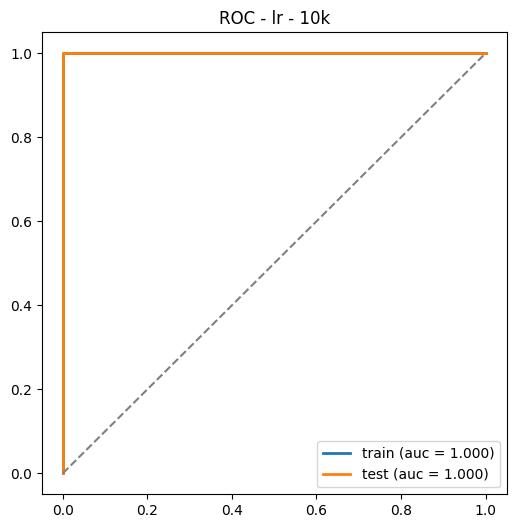

[2022-11-16 13:00:15,305] For the model "lr" trained on sample "10000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 0.004861575674242462, 'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:00:15,308] Data row: "lr	10000	1.0	0.004861575674242463	54.52257442474365".
[2022-11-16 13:00:15,347] Working on "30000" train sample.
[2022-11-16 13:00:15,349] Training a model "lr" on sample "30000".
[2022-11-16 13:00:15,349] Loading "30000" train samples.


[2022-11-16 13:00:17,292] Loaded "460" lines.
[2022-11-16 13:00:17,294] Training a model "lr" on sample "30000".


[2022-11-16 13:01:08,073] Training a model "lr" on sample "30000" took "50.7788" seconds.
[2022-11-16 13:01:08,074] Evaluating the model "lr" trained on sample "30000".


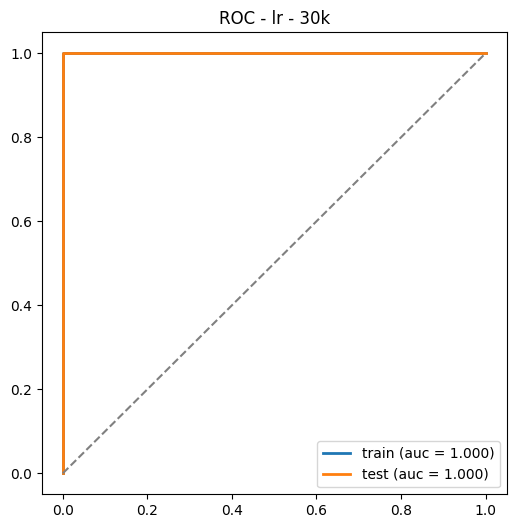

[2022-11-16 13:01:22,050] For the model "lr" trained on sample "30000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 0.004861575674242462, 'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:01:22,051] Data row: "lr	30000	1.0	0.004861575674242463	50.7787663936615".
[2022-11-16 13:01:22,055] Working on "100000" train sample.
[2022-11-16 13:01:22,056] Training a model "lr" on sample "100000".
[2022-11-16 13:01:22,057] Loading "100000" train samples.


[2022-11-16 13:01:23,935] Loaded "460" lines.
[2022-11-16 13:01:23,936] Training a model "lr" on sample "100000".


[2022-11-16 13:02:08,621] Training a model "lr" on sample "100000" took "44.6848" seconds.
[2022-11-16 13:02:08,622] Evaluating the model "lr" trained on sample "100000".


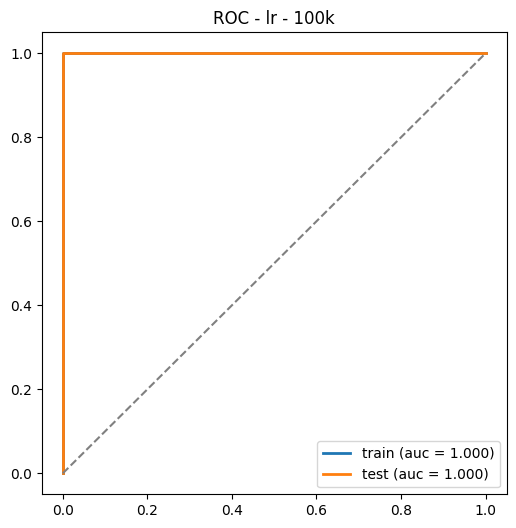

[2022-11-16 13:02:22,333] For the model "lr" trained on sample "100000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 0.004861575674242462, 'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:02:22,334] Data row: "lr	100000	1.0	0.004861575674242463	44.684805393218994".
[2022-11-16 13:02:22,337] Working on "300000" train sample.
[2022-11-16 13:02:22,338] Training a model "lr" on sample "300000".
[2022-11-16 13:02:22,339] Loading "300000" train samples.


[2022-11-16 13:02:24,146] Loaded "460" lines.
[2022-11-16 13:02:24,147] Training a model "lr" on sample "300000".


[2022-11-16 13:03:09,437] Training a model "lr" on sample "300000" took "45.2889" seconds.
[2022-11-16 13:03:09,438] Evaluating the model "lr" trained on sample "300000".


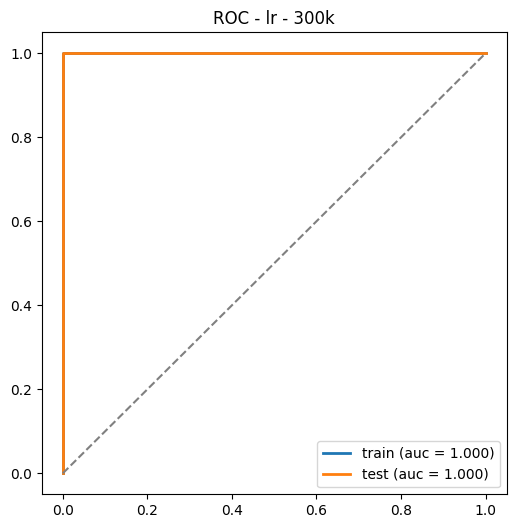

[2022-11-16 13:03:23,008] For the model "lr" trained on sample "300000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 0.004861575674242462, 'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:03:23,009] Data row: "lr	300000	1.0	0.004861575674242463	45.28892183303833".
[2022-11-16 13:03:23,012] Working on "1000000" train sample.
[2022-11-16 13:03:23,013] Training a model "lr" on sample "1000000".
[2022-11-16 13:03:23,014] Loading "1000000" train samples.


[2022-11-16 13:03:24,855] Loaded "460" lines.
[2022-11-16 13:03:24,856] Training a model "lr" on sample "1000000".


[2022-11-16 13:04:09,326] Training a model "lr" on sample "1000000" took "44.4685" seconds.
[2022-11-16 13:04:09,327] Evaluating the model "lr" trained on sample "1000000".


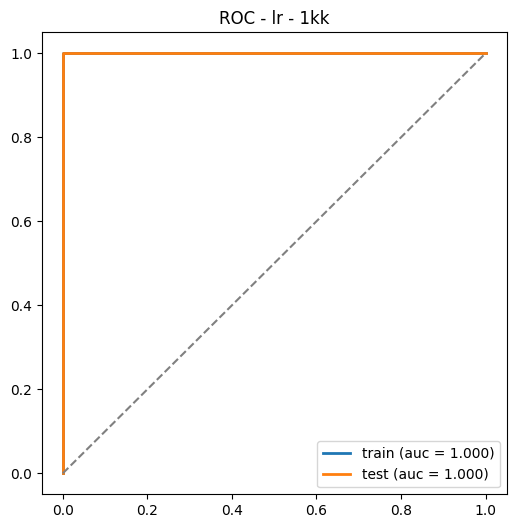

[2022-11-16 13:04:22,997] For the model "lr" trained on sample "1000000" metrics are: "{'train_roc_auc': 1.0, 'train_log_loss': 0.004861575674242462, 'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:04:22,998] Data row: "lr	1000000	1.0	0.004861575674242463	44.46853280067444".
[2022-11-16 13:04:23,002] Working on "3000000" train sample.
[2022-11-16 13:04:23,003] Training a model "lr" on sample "3000000".
[2022-11-16 13:04:23,003] Loading "3000000" train samples.


[2022-11-16 13:04:24,923] Loaded "460" lines.
[2022-11-16 13:04:24,924] Training a model "lr" on sample "3000000".


[2022-11-16 13:05:09,639] Training a model "lr" on sample "3000000" took "44.7139" seconds.
[2022-11-16 13:05:09,640] Evaluating the model "lr" trained on sample "3000000".


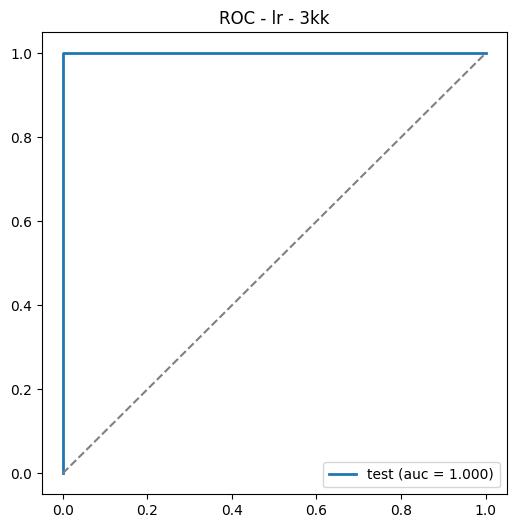

[2022-11-16 13:05:17,023] For the model "lr" trained on sample "3000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:05:17,025] Data row: "lr	3000000	1.0	0.004861575674242463	44.71393370628357".
[2022-11-16 13:05:17,028] Working on "10000000" train sample.
[2022-11-16 13:05:17,029] Training a model "lr" on sample "10000000".
[2022-11-16 13:05:17,030] Loading "10000000" train samples.


[2022-11-16 13:05:18,722] Loaded "460" lines.
[2022-11-16 13:05:18,723] Training a model "lr" on sample "10000000".


[2022-11-16 13:06:04,893] Training a model "lr" on sample "10000000" took "46.17" seconds.
[2022-11-16 13:06:04,894] Evaluating the model "lr" trained on sample "10000000".


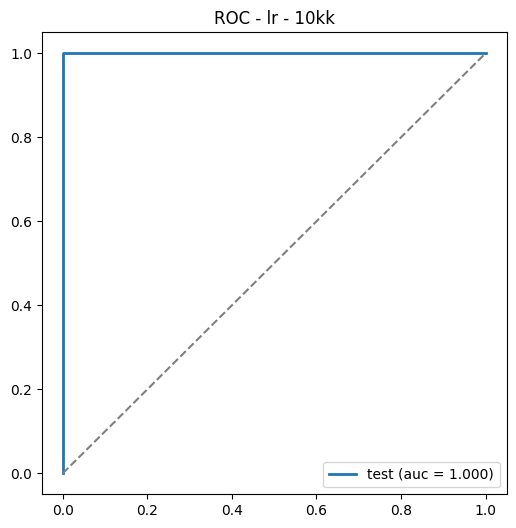

[2022-11-16 13:06:12,314] For the model "lr" trained on sample "10000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:06:12,315] Data row: "lr	10000000	1.0	0.004861575674242463	46.17001295089722".
[2022-11-16 13:06:12,317] Working on "30000000" train sample.
[2022-11-16 13:06:12,318] Training a model "lr" on sample "30000000".
[2022-11-16 13:06:12,318] Loading "30000000" train samples.


[2022-11-16 13:06:14,051] Loaded "460" lines.
[2022-11-16 13:06:14,052] Training a model "lr" on sample "30000000".


[2022-11-16 13:06:59,284] Training a model "lr" on sample "30000000" took "45.231" seconds.
[2022-11-16 13:06:59,285] Evaluating the model "lr" trained on sample "30000000".


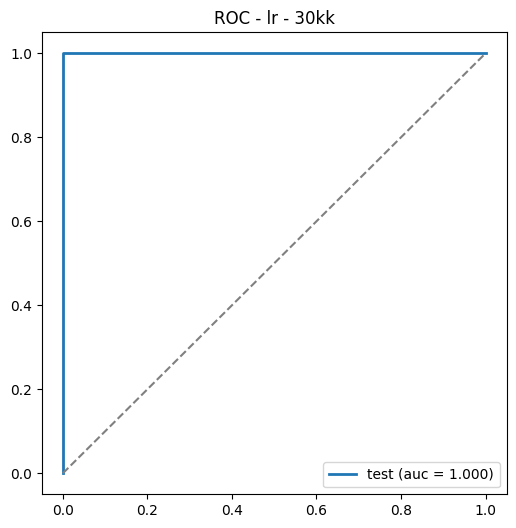

[2022-11-16 13:07:06,571] For the model "lr" trained on sample "30000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:07:06,572] Data row: "lr	30000000	1.0	0.004861575674242463	45.230950355529785".
[2022-11-16 13:07:06,576] Working on "100000000" train sample.
[2022-11-16 13:07:06,577] Training a model "lr" on sample "100000000".
[2022-11-16 13:07:06,578] Loading "100000000" train samples.


[2022-11-16 13:07:08,264] Loaded "460" lines.
[2022-11-16 13:07:08,265] Training a model "lr" on sample "100000000".


[2022-11-16 13:07:53,466] Training a model "lr" on sample "100000000" took "45.2008" seconds.
[2022-11-16 13:07:53,467] Evaluating the model "lr" trained on sample "100000000".


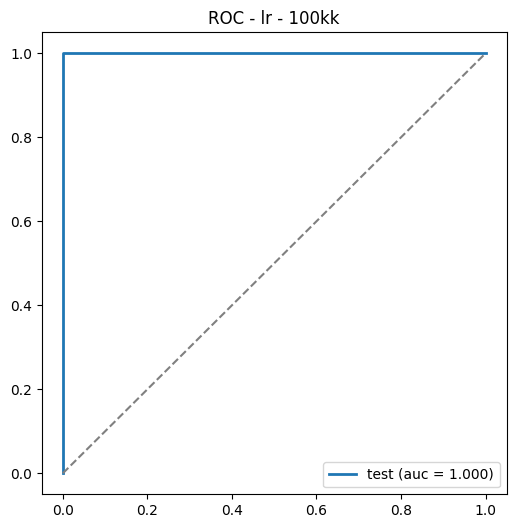

[2022-11-16 13:08:00,821] For the model "lr" trained on sample "100000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:08:00,824] Data row: "lr	100000000	1.0	0.004861575674242463	45.200777530670166".
[2022-11-16 13:08:00,827] Working on "300000000" train sample.
[2022-11-16 13:08:00,828] Training a model "lr" on sample "300000000".
[2022-11-16 13:08:00,830] Loading "300000000" train samples.


[2022-11-16 13:08:02,504] Loaded "460" lines.
[2022-11-16 13:08:02,505] Training a model "lr" on sample "300000000".


[2022-11-16 13:08:47,812] Training a model "lr" on sample "300000000" took "45.3069" seconds.
[2022-11-16 13:08:47,813] Evaluating the model "lr" trained on sample "300000000".


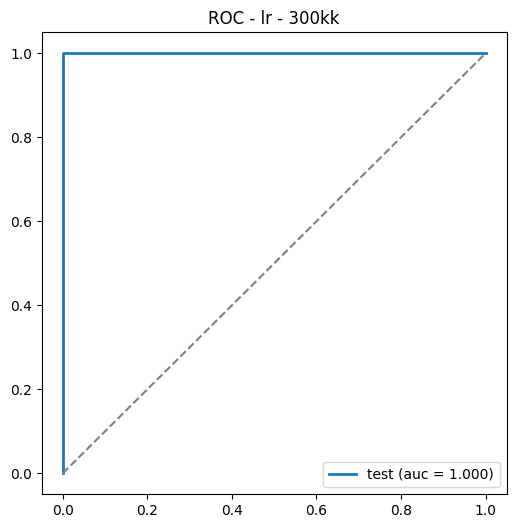

[2022-11-16 13:08:55,200] For the model "lr" trained on sample "300000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:08:55,201] Data row: "lr	300000000	1.0	0.004861575674242463	45.30687189102173".
[2022-11-16 13:08:55,203] Working on "1000000000" train sample.
[2022-11-16 13:08:55,204] Training a model "lr" on sample "1000000000".
[2022-11-16 13:08:55,205] Loading "1000000000" train samples.


[2022-11-16 13:08:56,841] Loaded "460" lines.
[2022-11-16 13:08:56,843] Training a model "lr" on sample "1000000000".


[2022-11-16 13:09:42,619] Training a model "lr" on sample "1000000000" took "45.7751" seconds.
[2022-11-16 13:09:42,620] Evaluating the model "lr" trained on sample "1000000000".


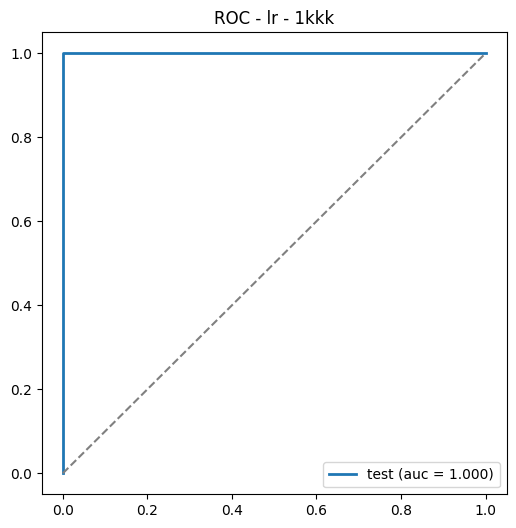

[2022-11-16 13:09:49,927] For the model "lr" trained on sample "1000000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:09:49,929] Data row: "lr	1000000000	1.0	0.004861575674242463	45.77511763572693".
[2022-11-16 13:09:49,931] Working on "3000000000" train sample.
[2022-11-16 13:09:49,933] Training a model "lr" on sample "3000000000".
[2022-11-16 13:09:49,934] Loading "3000000000" train samples.


[2022-11-16 13:09:51,584] Loaded "460" lines.
[2022-11-16 13:09:51,585] Training a model "lr" on sample "3000000000".


[2022-11-16 13:10:37,893] Training a model "lr" on sample "3000000000" took "46.3071" seconds.
[2022-11-16 13:10:37,894] Evaluating the model "lr" trained on sample "3000000000".


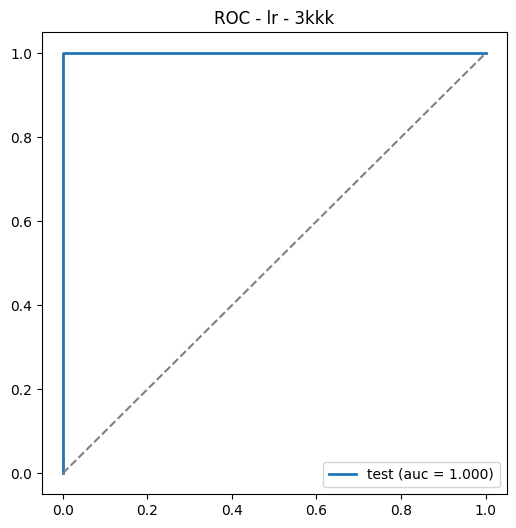

[2022-11-16 13:10:45,256] For the model "lr" trained on sample "3000000000" metrics are: "{'test_roc_auc': 1.0, 'test_log_loss': 0.004861575674242463}"; ROC AUC calculated by Spark is "1.0".
[2022-11-16 13:10:45,257] Data row: "lr	3000000000	1.0	0.004861575674242463	46.30709099769592".
time: 11min 47s (started: 2022-11-16 12:58:57 +00:00)


In [21]:
import time

from pyspark.ml.evaluation import BinaryClassificationEvaluator


test_sample = test_samples[-1]

evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='probability', metricName='areaUnderROC')

new_quality_data = []
new_data_rows = []

test_dfs = dict()

logger.info('Loading "%s" test samples.', test_sample)
print(libsvm_test_template)

test_df = load_ml_data(libsvm_test_template, test_sample)

with test_df:
    logger.info('Loaded "%s" lines.', test_df.count())

    for train_sample in train_samples:

        logger.info('Working on "%s" train sample.', train_sample)

        for classifier_name, classifier in classifiers.items():

            logger.info('Training a model "%s" on sample "%s".', classifier_name, train_sample)

            logger.info('Loading "%s" train samples.', train_sample)
            train_df = load_ml_data(libsvm_train_template, train_sample)
            with train_df:
                logger.info('Loaded "%s" lines.', train_df.count())
                
                logger.info('Training a model "%s" on sample "%s".', classifier_name, train_sample)

                start = time.time()
                model = classifier.fit(train_df)
                duration = time.time() - start

                logger.info('Training a model "%s" on sample "%s" took "%g" seconds.', classifier_name, train_sample, duration)

                logger.info('Evaluating the model "%s" trained on sample "%s".', classifier_name, train_sample)
                metrics = evaluate_model(classifier_name + ' - ' + sample_name(train_sample), model, test_df, train=(train_df if train_sample <= 1000000 else None))

                test_predictions = model.transform(test_df)
                ml_metric_value = evaluator.evaluate(test_predictions)

                logger.info(
                    'For the model "%s" trained on sample "%s" metrics are: "%s"; ROC AUC calculated by Spark is "%s".',
                    classifier_name,
                    train_sample,
                    metrics,
                    ml_metric_value,
                )

                data_row = {
                    'Train size': train_sample,
                    'ROC AUC': metrics['test_roc_auc'],
                    'Log loss': metrics['test_log_loss'],
                    'Duration': duration,
                    'Engine': classifier_name,
                }
                new_quality_data.append(data_row)
                data_row_string = '\t'.join(str(data_row[field]) for field in ['Engine', 'Train size', 'ROC AUC', 'Log loss', 'Duration'])
                new_data_rows.append(data_row_string)
                logger.info('Data row: "%s".', data_row_string)

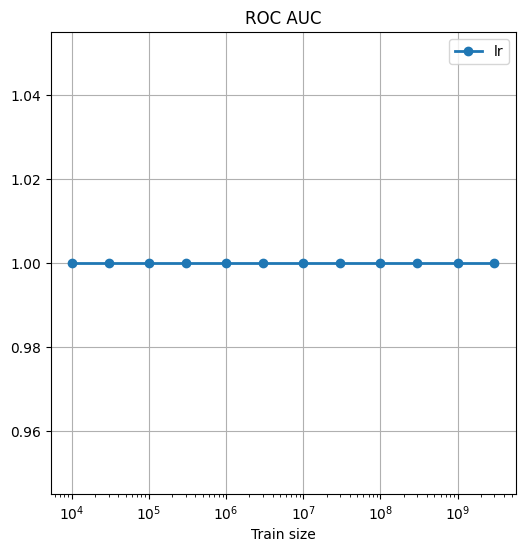

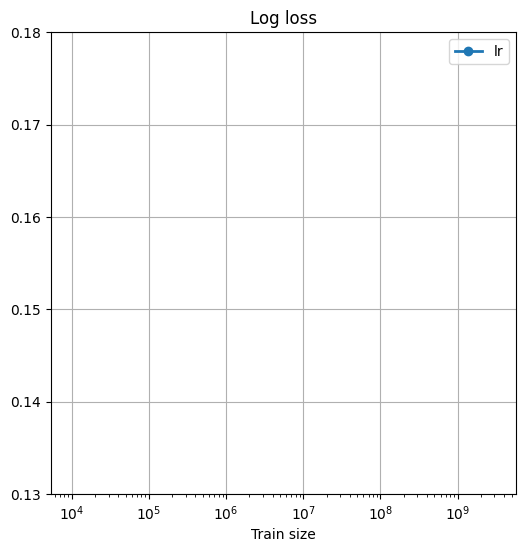

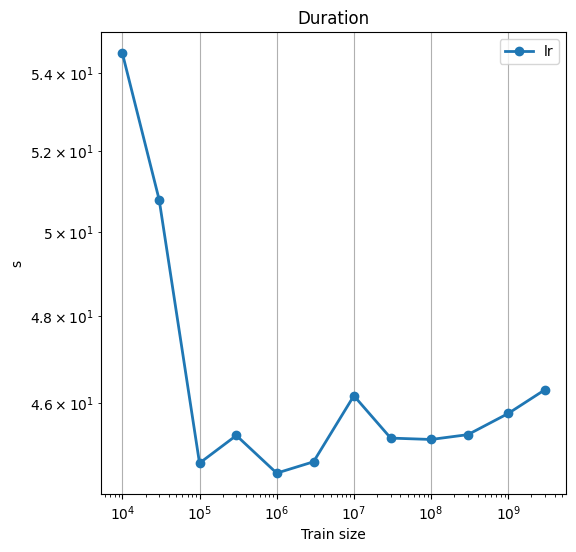

time: 1.12 s (started: 2022-11-16 13:10:45 +00:00)


In [22]:
measurements_df = pandas.DataFrame(new_quality_data).sort_values(by=['Train size'])
plot_stuff(measurements_df, 'ROC AUC', logx=True)
plot_stuff(measurements_df, 'Log loss', logx=True, ylim=(0.13, 0.18))
plot_stuff(measurements_df, 'Duration', loglog=True, ylabel='s')

In [23]:
for row in new_data_rows:
    print(row)

lr	10000	1.0	0.004861575674242463	54.52257442474365
lr	30000	1.0	0.004861575674242463	50.7787663936615
lr	100000	1.0	0.004861575674242463	44.684805393218994
lr	300000	1.0	0.004861575674242463	45.28892183303833
lr	1000000	1.0	0.004861575674242463	44.46853280067444
lr	3000000	1.0	0.004861575674242463	44.71393370628357
lr	10000000	1.0	0.004861575674242463	46.17001295089722
lr	30000000	1.0	0.004861575674242463	45.230950355529785
lr	100000000	1.0	0.004861575674242463	45.200777530670166
lr	300000000	1.0	0.004861575674242463	45.30687189102173
lr	1000000000	1.0	0.004861575674242463	45.77511763572693
lr	3000000000	1.0	0.004861575674242463	46.30709099769592
time: 349 µs (started: 2022-11-16 13:10:46 +00:00)


## End
[_(back to toc)_](#Table-of-contents)

Work done, stop Spark:

In [24]:
spark.stop()

time: 1.17 s (started: 2022-11-16 13:10:46 +00:00)
